In [2]:
import os
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from thop import profile
import pandas as pd
from collections import defaultdict
import tqdm
import numpy as np

In [20]:
DATA_DIR = "C:\\Users\\nisad\\Desktop\\YapayZeka Uygulama\\archive\\images"
BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [21]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [24]:
class FoodDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.transform = transform
        self.samples = []
        for cls in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, cls)
            if not os.path.isdir(class_dir): continue
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.samples.append((img_path, cls))
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        img_tensor = self.transform(img)
        return img_tensor, label, path


In [29]:
def load_model(model_name):
    if  model_name == "densenet121":
        model = models.densenet121(pretrained=True)
        model.classifier = torch.nn.Identity()
    elif model_name == "mobilenet_v3_large":
        model = models.mobilenet_v3_large(pretrained=True)
        model.classifier = torch.nn.Identity()
    elif model_name == "vgg16":
        model = models.vgg16(pretrained=True)
        model.classifier = torch.nn.Sequential(*list(model.classifier.children())[:-1])
    else:
        raise ValueError(f"Bilinmeyen model: {model_name}")
    
    return model.to(DEVICE).eval()


In [30]:
def extract_all_features(dataset, model):
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)
    vectors, labels, paths = [], [], []
    with torch.no_grad():
        for imgs, lbls, pths in tqdm(dataloader, desc="Özellik çıkarılıyor"):
            imgs = imgs.to(DEVICE)
            feats = model(imgs).cpu()
            vectors.append(feats)
            labels.extend(lbls)
            paths.extend(pths)
    return torch.cat(vectors), labels, paths


In [34]:
dataset = FoodDataset(DATA_DIR, transform)

# Modellerin listesi
model_names = [ "densenet121", "mobilenet_v3_large", "vgg16"]

# Her model için özellik çıkarımı ve kayıt
for name in model_names:
    print(f"\n🔍 İşleniyor: {name.upper()}")
    model = load_model(name)
    features, labels, paths = extract_all_features(dataset, model)

    torch.save(features, f"features_{name}.pt")
    with open(f"meta_{name}.txt", "w") as f:
        for lbl, p in zip(labels, paths):
            f.write(f"{lbl}|||{p}\n")

    print(f"✅ Kayıt tamamlandı: features_{name}.pt ve meta_{name}.txt")


🔍 İşleniyor: DENSENET121


Özellik çıkarılıyor: 100%|██████████| 3157/3157 [1:38:40<00:00,  1.88s/it]


✅ Kayıt tamamlandı: features_densenet121.pt ve meta_densenet121.txt

🔍 İşleniyor: MOBILENET_V3_LARGE


c:\Users\nisad\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to C:\Users\nisad/.cache\torch\hub\checkpoints\mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:49<00:00, 445kB/s]
Özellik çıkarılıyor: 100%|██████████| 3157/3157 [43:09<00:00,  1.22it/s]


✅ Kayıt tamamlandı: features_mobilenet_v3_large.pt ve meta_mobilenet_v3_large.txt

🔍 İşleniyor: VGG16


c:\Users\nisad\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\nisad/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [40:51<00:00, 226kB/s]    
Özellik çıkarılıyor: 100%|██████████| 3157/3157 [2:52:28<00:00,  3.28s/it]  


✅ Kayıt tamamlandı: features_vgg16.pt ve meta_vgg16.txt



🔍 Model: RESNET50


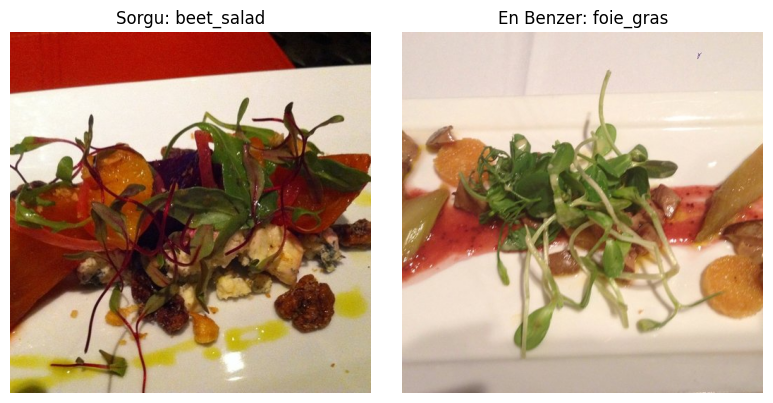

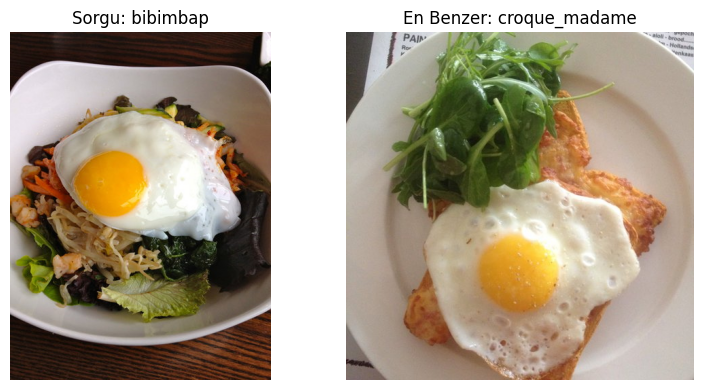

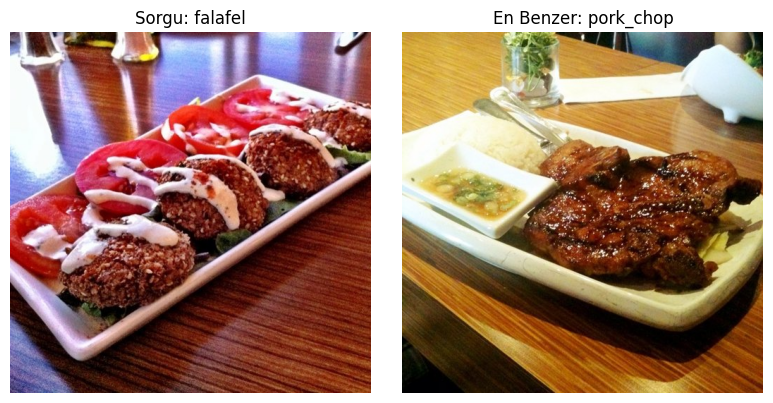

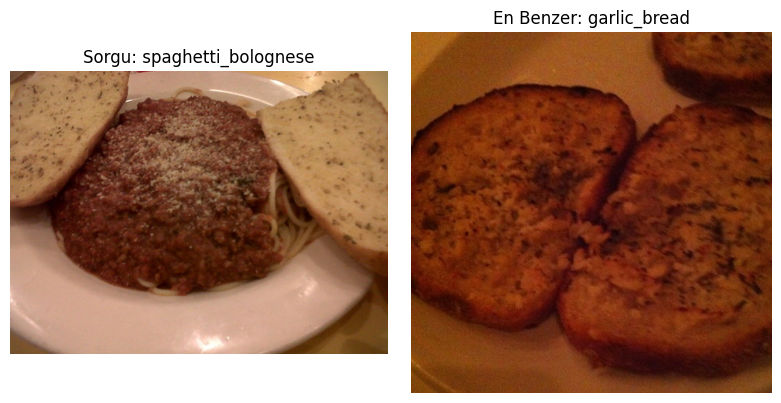


🔍 Model: DENSENET121


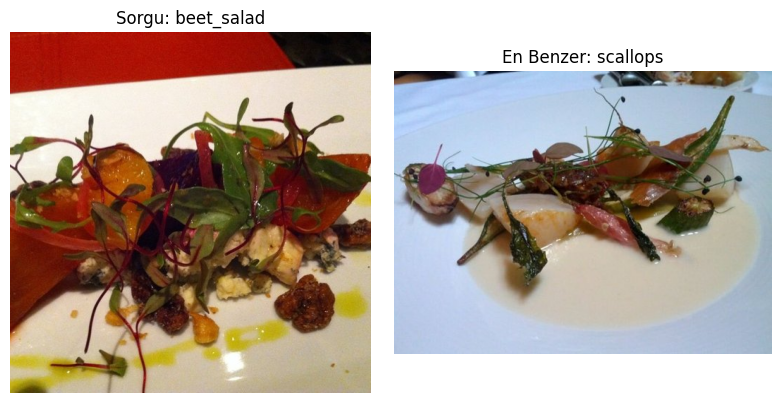

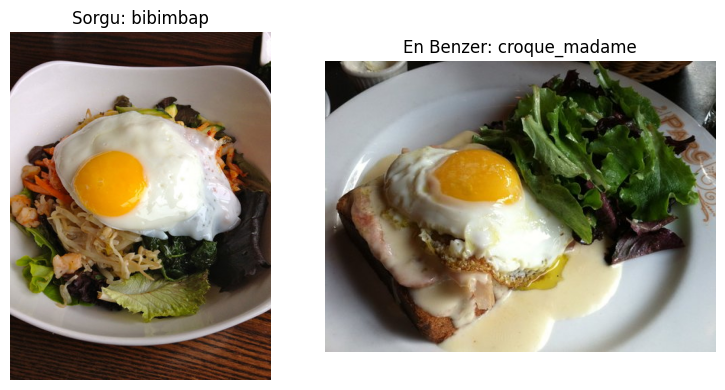

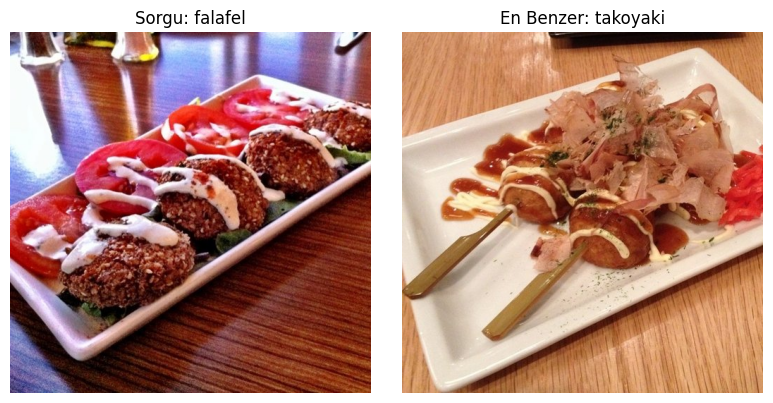

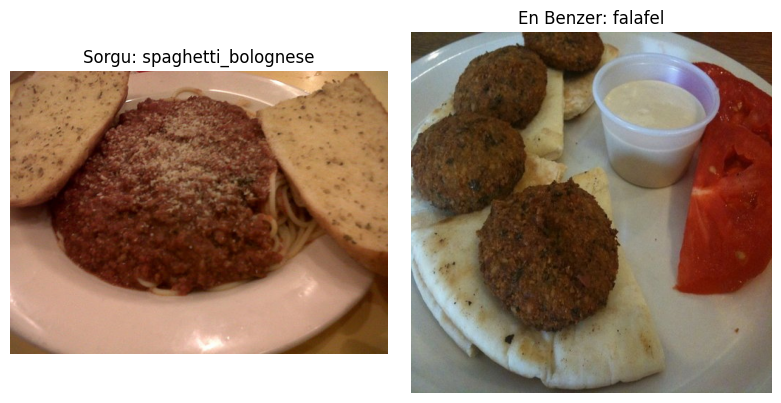


🔍 Model: MOBILENET_V3_LARGE


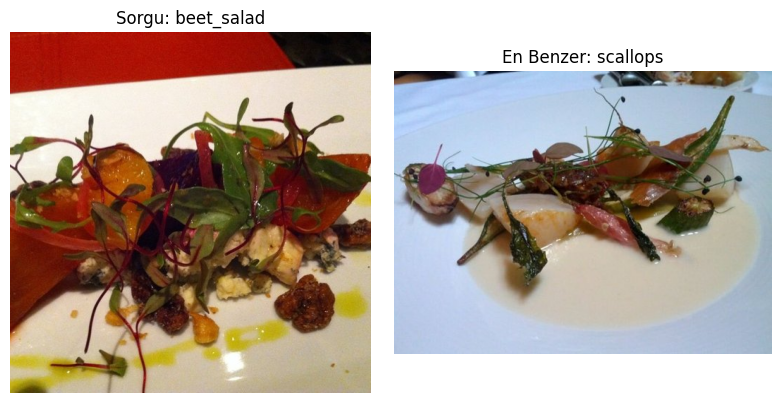

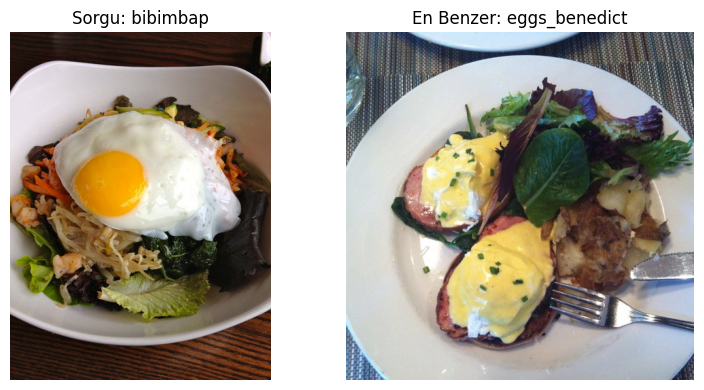

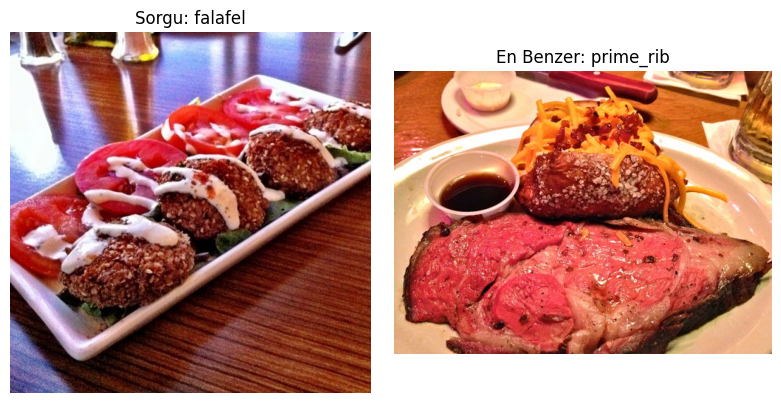

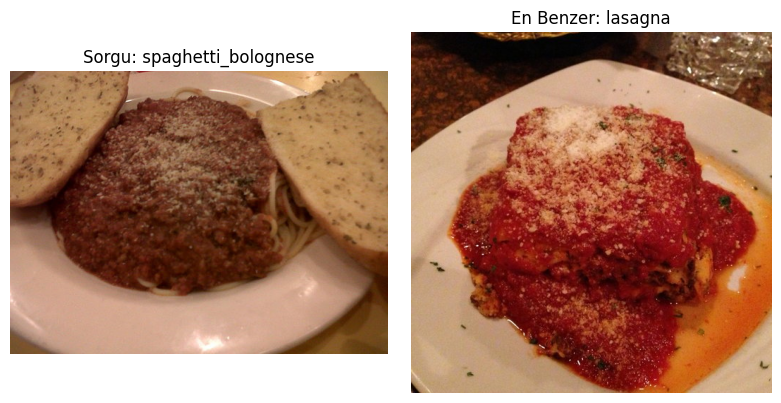


🔍 Model: VGG16


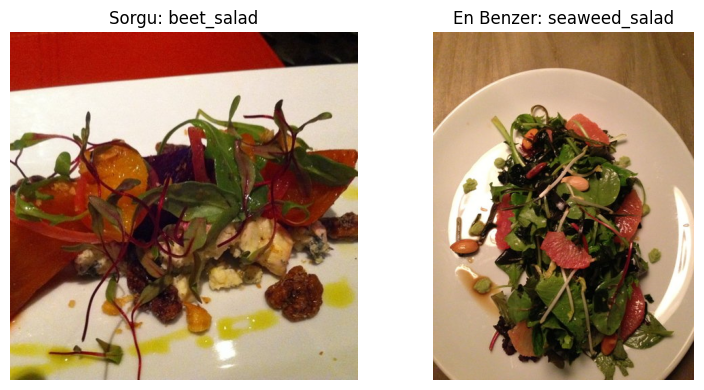

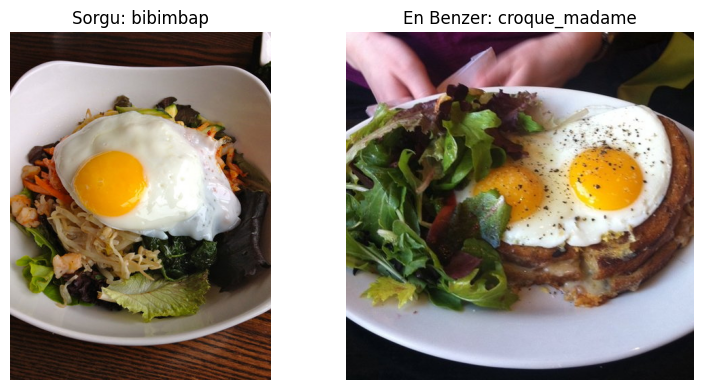

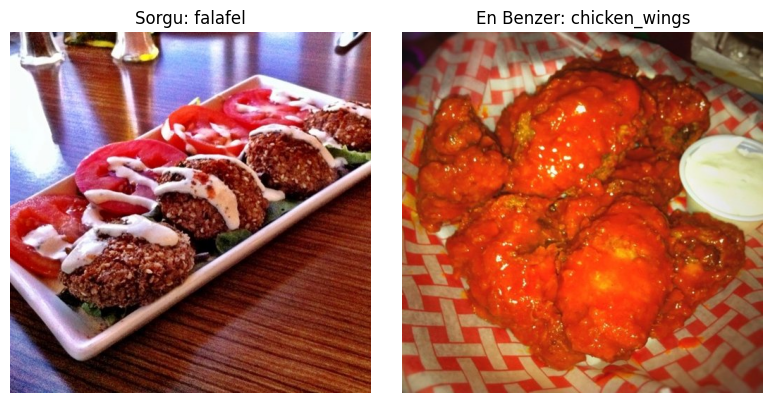

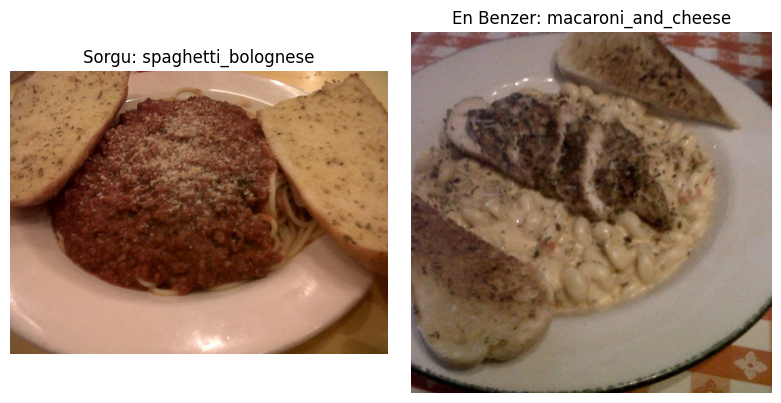

In [ ]:
def find_most_similar(query_label, vectors, labels, paths, exclude_same_class=False):
    for i, lbl in enumerate(labels):
        if lbl == query_label:
            query_vec = vectors[i]
            break
    else:
        print("Sınıf bulunamadı.")
        return

    sims = F.cosine_similarity(query_vec.unsqueeze(0), vectors)

    if exclude_same_class:
        # Aynı sınıftan olanlara -1 verdim, sıralamaya girmesin diye
        for j, lbl in enumerate(labels):
            if lbl == query_label:
                sims[j] = -1
    else:
        sims[i] = -1  # sadece kendisini dışla

    top_idx = torch.topk(sims, k=1).indices[0].item()

    query_img = Image.open(paths[i])
    best_img = Image.open(paths[top_idx])

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(query_img)
    plt.title(f"Sorgu: {labels[i]}")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(best_img)
    plt.title(f"En Benzer: {labels[top_idx]}")
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    
# ------------------ Ana Çalıştırıcı ------------------
if __name__ == "__main__":
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    for model_name in ["resnet50","densenet121", "mobilenet_v3_large", "vgg16"]:
        print(f"\n🔍 Model: {model_name.upper()}")

        vectors = torch.load(f"features_{model_name}.pt")
        with open(f"meta_{model_name}.txt", "r") as f:
            meta_lines = f.readlines()
        labels = [line.split("|||")[0] for line in meta_lines]
        paths = [line.strip().split("|||")[1] for line in meta_lines]

        
        find_most_similar("beet_salad", vectors, labels, paths,exclude_same_class=True)         
        find_most_similar("bibimbap", vectors, labels, paths,exclude_same_class=True)         
        find_most_similar("falafel", vectors, labels, paths,exclude_same_class=True)       
        find_most_similar("spaghetti_bolognese", vectors, labels, paths,exclude_same_class=True)

In [ ]:

def evaluate_all_metrics(vectors, labels, top_k=5, num_samples_per_class=2):
    class_to_indices = defaultdict(list)
    for i, lbl in enumerate(labels):
        class_to_indices[lbl].append(i)
    total = correct_top1 = correct_topk = 0
    precision_sum = map_sum = ndcg_sum = 0
    for cls, idx_list in tqdm.tqdm(class_to_indices.items()):
        sampled = idx_list[:num_samples_per_class]
        for query_idx in sampled:
            query_vec = vectors[query_idx]
            sims = F.cosine_similarity(query_vec.unsqueeze(0), vectors)
            sims[query_idx] = -1
            topk_indices = torch.topk(sims, k=top_k).indices.tolist()
            retrieved_labels = [labels[i] for i in topk_indices]
            relevant = [1 if lbl == cls else 0 for lbl in retrieved_labels]
            if retrieved_labels[0] == cls: correct_top1 += 1
            if any(relevant): correct_topk += 1
            precision_sum += sum(relevant) / top_k
            num_rel = 0; ap = 0
            for i, rel in enumerate(relevant):
                if rel:
                    num_rel += 1
                    ap += num_rel / (i + 1)
            map_k = ap / max(1, sum(relevant))
            map_sum += map_k
            def dcg(rels): return sum([rel / np.log2(i+2) for i, rel in enumerate(rels)])
            ideal = sorted(relevant, reverse=True)
            ndcg = dcg(relevant) / (dcg(ideal) + 1e-8)
            ndcg_sum += ndcg
            total += 1
    print(f"Top-1 Accuracy:     {correct_top1 / total:.4f}")
    print(f"Top-{top_k} Accuracy:  {correct_topk / total:.4f}")
    print(f"Recall@{top_k}:     {correct_topk / total:.4f}")
    print(f"Precision@{top_k}:  {precision_sum / total:.4f}")
    print(f"MAP@{top_k}:         {map_sum / total:.4f}")
    print(f"NDCG@{top_k}:        {ndcg_sum / total:.4f}")

models_to_test = [ "resnet50", "densenet121", "mobilenet_v3_large", "vgg16"]

for model_name in models_to_test:
    print(f"\n🔍 Model: {model_name.upper()}")

    vectors = torch.load(f"features_{model_name}.pt")
    with open(f"meta_{model_name}.txt", "r") as f:
        meta_lines = f.readlines()
    labels = [line.split("|||")[0] for line in meta_lines]

    evaluate_all_metrics(vectors, labels, top_k=5, num_samples_per_class=2)


🔍 Model: RESNET50


100%|██████████| 101/101 [02:02<00:00,  1.21s/it]


Top-1 Accuracy:     0.4455
Top-5 Accuracy:  0.6881
Recall@5:     0.6881
Precision@5:  0.3950
MAP@5:         0.5166
NDCG@5:        0.5690

🔍 Model: DENSENET121


100%|██████████| 101/101 [00:59<00:00,  1.69it/s]


Top-1 Accuracy:     0.4703
Top-5 Accuracy:  0.7277
Recall@5:     0.7277
Precision@5:  0.4079
MAP@5:         0.5402
NDCG@5:        0.5971

🔍 Model: MOBILENET_V3_LARGE


100%|██████████| 101/101 [00:56<00:00,  1.78it/s]


Top-1 Accuracy:     0.5644
Top-5 Accuracy:  0.7426
Recall@5:     0.7426
Precision@5:  0.4564
MAP@5:         0.5982
NDCG@5:        0.6458

🔍 Model: VGG16


100%|██████████| 101/101 [04:48<00:00,  2.85s/it]

Top-1 Accuracy:     0.4109
Top-5 Accuracy:  0.6188
Recall@5:     0.6188
Precision@5:  0.3426
MAP@5:         0.4644
NDCG@5:        0.5117


In [ ]:
# Model isimleri ve fonksiyonları
model_defs = {
    "ResNet50": models.resnet50,
    "DenseNet121": models.densenet121,
    "MobileNetV3-Large": models.mobilenet_v3_large,
    "VGG16": models.vgg16
}

# örnek resim
input_tensor = torch.randn(1, 3, 224, 224)

# Sonuçları sakla
results = []

# Hesaplama
for name, model_fn in model_defs.items():
    model = model_fn(pretrained=False)
    model.eval()
    flops, params = profile(model, inputs=(input_tensor,), verbose=False)
    results.append({
        "Model": name,
        "Parameters (M)": round(params / 1e6, 2),
        "FLOPs (G)": round(flops / 1e9, 2)
    })



df = pd.DataFrame(results)
print(df)


c:\Users\nisad\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nisad\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


               Model  Parameters (M)  FLOPs (G)
0           ResNet50           25.56       4.13
1        DenseNet121            7.98       2.90
2  MobileNetV3-Large            5.48       0.23
3              VGG16          138.36      15.47


In [ ]:

simple_classes = ['pizza', 'hamburger', 'hot_dog', 'french_fries']
complex_classes = ['bibimbap', 'beet_salad', 'paella', 'foie_gras']

model_names = ["resnet50", "densenet121", "mobilenet_v3_large", "vgg16"]

results = []

for name in model_names:
    vectors = torch.load(f"features_{name}.pt")
    with open(f"meta_{name}.txt", "r") as f:
        lines = f.readlines()

    labels = [line.split("|||")[0] for line in lines]
    paths = [line.strip().split("|||")[1] for line in lines]

    label_to_indices = defaultdict(list)
    for i, lbl in enumerate(labels):
        label_to_indices[lbl].append(i)

    for group_name, class_list in [('Simple', simple_classes), ('Complex', complex_classes)]:
        total, correct = 0, 0
        for cls in class_list:
            if cls not in label_to_indices:
                continue
            query_indices = label_to_indices[cls][:5]  # sınıf başına 5 örnek
            for idx in query_indices:
                query_vec = vectors[idx]
                sims = F.cosine_similarity(query_vec.unsqueeze(0), vectors)
                sims[idx] = -1
                top_idx = torch.topk(sims, k=1).indices[0].item()
                if labels[top_idx] == cls:
                    correct += 1
                total += 1
        acc = correct / total if total else 0
        results.append({
            "Model": name.upper(),
            "Group": group_name,
            "Accuracy": round(acc, 4)
        })

# Tabloya dök
df_complexity = pd.DataFrame(results)
df_complexity.pivot(index="Model", columns="Group", values="Accuracy")


Group               Complex  Simple
Model                              
DENSENET121            0.30    0.60
MOBILENET_V3_LARGE     0.60    0.70
RESNET50               0.35    0.60
VGG16                  0.10    0.65